In [9]:
%matplotlib inline

>*" Worldwide, some 270,000 pedestrians die each year (2020 data); that is around one fifth of all road traffic deaths.  In the USA, they account for 18% of fatalities, UK 41%, Poland 46%. Smartphone texting has been linked to compromised pedestrian safety in a 2020 study published in the journal Injury Prevention. According to research conducted by Canadian researchers, there are higher rates of ‘near misses’ and failure to look left and right before crossing a road while texting or talking on the phone. "*<br>

- The Encyclopedia of World Problems and Human Potential

> *" Roadkill was found to be the most common cause of death in almost a third (28%) of all populations studied—ahead of causes such as disease, hunting and predation by other animals. A further 30% and 32% of all populations, respectively, experienced road deaths as their second and third largest cause of death. "* <br>

- Demographic effects of road mortality on mammalian populations: a systematic review, Lauren J. Moore, Silviu O. Petrovan, Adam J. Bates, Helen L. Hicks, Philip J. Baker, Sarah E. Perkins, Richard W. Yarnell

> *" Remember, that we all are brothers <br>
All people, beasts, trees and stone and wind <br>
We all descend from the one great being <br>
That was always there <br>
Before people lived and named it <br>
Before the first seed sprouted "* <br>

- Heilung, Opening Ceremony Lyrics

# **Can we use dashcam videos to detect persons, dogs and cats in realtime?**
Author: *Preslav Penev, Data Science Training Softuni 2023*

## Introduction
The problem we will explore is can we train a model to detect persons, cats and dogs crossing or standing on the roadway from a moving vehicle with a satisfactory accuracy rate. A practical application would be to implement such a model into dashcams to avoid accidents and roadkill by warning the driver. We will have lots of problems here - limited amount of annotated input data, low resolution videos, distortions from rain drops and stain, poor lighting conditions, motion blur. Dashcam footage might have lens flare too, reflections on the windshield etc. First we will explore the overall light distribution in all frames extracted. Then we wil show the objects spacial distribution over the frames dataset. 
We will make an initial preprocess and augmentation over the collected frames to improve their quality and to create diversity over the training dataset. We need realtime detection so we will train and evaluate a detector using the YOLO v4 Darknet model as a state-of-art model proven in such tasks. We will make 3 iterations to train the model fine-tunning the input data after every iteration. In the end we will analyse and summarise the results. We will demonstrate the most important model evaluation metrics and even deploy a simple objects detector in the notebook. So

<!-- After that we will compare the model with the SSD - [Single Shot MultiBox Detector model for object detection](https://colab.research.google.com/github/pytorch/pytorch.github.io/blob/master/assets/hub/nvidia_deeplearningexamples_ssd.ipynb).
 -->

**First thing first**

In [224]:
import os
import requests
import random
import cv2
import dask
from dask import delayed, compute
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import exposure, img_as_float, io
from skimage.io import imread, imshow
import seaborn as sns
from sklearn.metrics import (average_precision_score, confusion_matrix, precision_recall_curve)
from tqdm import tqdm
import roboflow
from evaluation_module import compute_iou, evaluate_model_performance
from eda_viz import plot_label_centers, plot_aspect_ratios_and_areas, plot_img_and_hist, random_grid

## 1. Data acquisition, cleaning, tyding, annotating
The dataset is aquired from youtube dashcam videos with Easy Youtube Video Downloader plugin for Firefox and own smartphone videos and consists of around 2900 frames . Unfortunately the videos from dashcams are with very poor quality with average image size 0.92 mpx, but they are the closest to the reality visual material. Every frame in the dataset is with equal size 1280 x 720 px. The initial framerate used for the extraction of the images is  27 fps. Frames are annotated with labelImg - https://pypi.org/project/labelImg/ in the YOLO Darknet inline `*.txt` format. Annotations are extracted from source directories downloaded from Roboflow with `extract_annotations.py`.Predictions are extracted with `extract_predictions.py` tweaking the Roboflow API, which return JSON for every image:

`{'predictions': [{'x': 575.0, 'y': 363.0, 'width': 166.0, 'height': 174.0, 'confidence': 0.9233824014663696, 'class': 'person', 'image_path': 'data/images/1691943836_998905.jpg', 'prediction_type': 'ObjectDetectionModel'}], 'image': {'width': '1280', 'height': '720'}}`

**Downloading the dataset.**

The dataset consist of three directories `images`, `labels` and `static`. In `images` we can find all images  with unique file names. In `labels` we can find all annotated bounding boxes with file names corresponding to the particular images. In `static` directory we can find images of plots during the training process. The annotation format is YOLO v4 inline text `<object-class> <x> <y> <width> <height>`. The archive contains also seven `csv` files which contain the information for the bounding boxes in all frames, ground_truth and predicted datasets for every model training iteration.

Now lets dowload the data!

In [271]:
##Downloading the dataset.
##If on Linux:
#!wget http://preslaff.laboletory.com/preslaff/data_science_final_project/data.zip
##Then unzip the file

#Python code
url = "http://preslaff.laboletory.com/preslaff/data_science_final_project/data.zip"
output_file_path = "data.zip"

response = requests.get(url, stream=True)

if response.status_code == 200:
    total_size = int(response.headers.get('content-length', 0))
    chunk_size = 1024  # You can adjust the chunk size as needed
    progress_bar = tqdm(total=total_size, unit='B', unit_scale=True)

    with open(output_file_path, "wb") as f:
        for data in response.iter_content(chunk_size=chunk_size):
            progress_bar.update(len(data))
            f.write(data)

    progress_bar.close()
    print("File downloaded successfully.")
else:
    print("Failed to download the file.")

#Or just copy and paste in your browser the hyperlink http://preslaff.laboletory.com/preslaff/data_science_final_project/data.zip 

100%|████████████████████████████████████████████████████████████████████████████████████████| 400M/400M [02:52<00:00, 2.31MB/s]

File downloaded successfully.


> After downloading we have to extract the archive.

## 2. Exploratory Data Analysis

### 2.1. First look over the data

Below is a grid of sample frames aquired from dashcam youtube videos and own records.

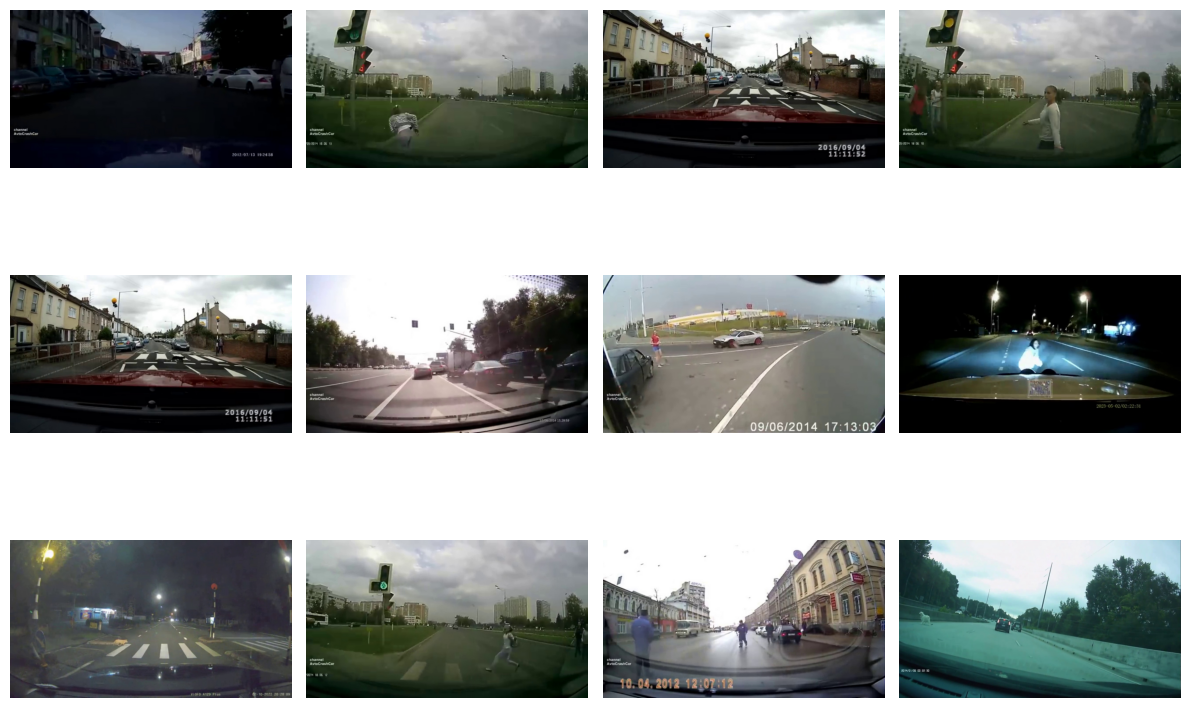

In [227]:
random_grid('data/images')

As we can see, they all show the road ahead through the windshield of a vehicle under different weather conditions and different light exposure. It is very possibble that all footages are made with different models of dashcams.

### 2.2. Reading all frames pixels

Now lets process the frames to `np.arrays` for further exploration. For this task we will use OpenCV which is an open-source library that was developed by Intel in the year 2000. It is mostly used in computer vision tasks such as object detection, face detection, face recognition, image segmentation and is convinient for our task. We will use parallel processing with Dask to process the images. It is a better approach when dealing with large amount of files.

First let's make a function to read one frame and put it in a np.array.

In [228]:
@delayed
def process_image(path):
    """
        Reads an images from path direcotry and returns its pixel values in  1-D np.array

        Parameters:
        path -> str

        Returns:
        img.ravel() -> 1-D np.array
    """
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return img.ravel()

Now let's walk around the directory with the original frames and put them together. We want to see the light distribution in all frames. 

In [229]:
# Walk through directory and subdirectories to collect all .jpg paths
image_paths = []
for dirpath, dirnames, filenames in os.walk('data/images'):
    for filename in [f for f in filenames if f.endswith(".jpg")]:
        image_paths.append(os.path.join(dirpath, filename))

# Use Dask delayed to process images
pixel_values = [process_image(path) for path in image_paths]

# Compute results
results = compute(*pixel_values)

# Flatten list of arrays to single array
all_pixel_values = np.concatenate(results)

The `all_pixel_values` is an array containing all pixels from all frames. We will plot it down below in chapter 2.3. to see a histogram of all pixels intensity.

### 2.3. Exploring the light characteristics of the dataset

What is one important feauture of an image? It is the light. Let's see the overall distribution of the light in all frames in the dataset.

Plotting the data in the metric `Frequency` which comes from the probability density function (PDF) with `density=True`, where `Frequency`:

\begin{align}
\text{Frequency} = \frac{\text{Count}}{\text{Total number of data points} \times \text{Width of bin}}
\end{align}

Actually the histogram with `density=False` is the same but we will later compare this distribution with the augmented dataset distribution wich will be 3 x times bigger, so we need a suitable metric.

**Pixel intensity histogram for all pixels in the dataset**

We will draw a histogram from all 2900 frames to check the pixel intensity.

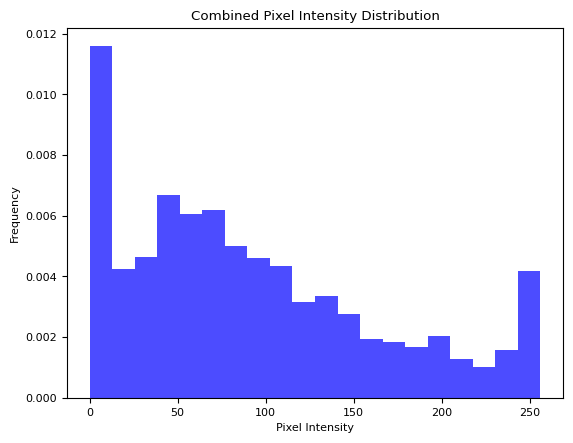

In [263]:
#Draws histogram of all the pixel intensity
plt.hist(all_pixel_values, bins=20, range=(0,256), density=True, color='blue', alpha=0.7)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Combined Pixel Intensity Distribution')
plt.show()  

What we can see is that there are a lot of too dark and too bright pixels. It is a very good idea to enhance the **contrast** before we start training the model.

**Histogram equalization scenarios of a sample picture**

Now we load the sample image and apply transformations to rescale, histogram equilization and adaptive histogram equilization.

In [267]:
# Load an example image with transforations
img = imread("data/images/1691943419_470892.jpg")
# img = np.mean(img, axis=-1)/255
# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    
# Equalization

img_eq = exposure.equalize_hist(img)
    
# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

No worries, we want to see the color images. Let's plot the results. 

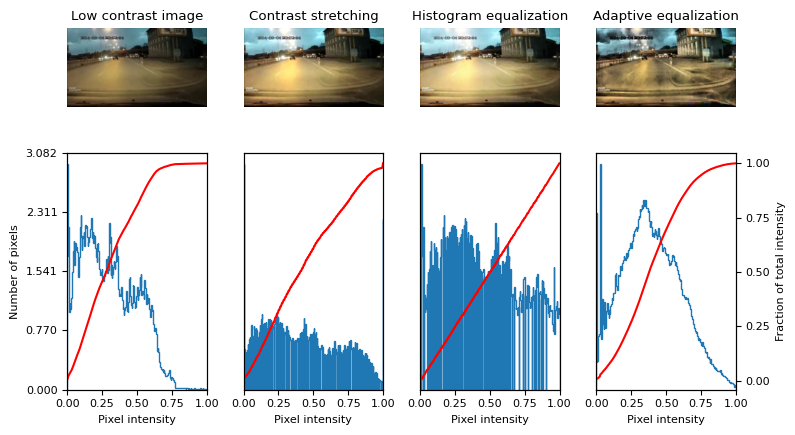

In [268]:
# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 4), dtype=object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

Here we can compare the effect of the histogram equalization over one sample frame. As we can see some of the transformations give promising results. The Adaptive Histogram Equalization (AHE) is an enhancement technique used in image processing to improve the local contrast of an image. While standard histogram equalization works by redistributing the intensity values across the entire image histogram. AHE takes into account local regions of the image, allowing for better preservation of local details and avoiding over-amplification of noise. The selected frame is from nighly dashcam footage to better visualise the effect of AHE. As the AHE gives too distorted results adding additional noise, it is not sure that the model will benefir from it. May be one simple brightness adjustment or exposure transformatio will do the work. it will not be certain until we train the model and analyse the results, but is an option.

### 2.4. Bounding box spacial and structural analysis

Now let's explore the distribution of all annotated objects in all classes. We use bounding box spatial analysis to study and analyze the spatial relationships, characteristics, and interactions of bounding boxes. We will plot the bounding boxes' centroids, next we will plot bounding boxes aspect ratio and areas .

But now we will read `all_frames.csv` which contains all bounding boxes annotated by us. We will rename the columns and make some check ups to see the data types, finding missing information, an see some statistics about the dataset.

In [233]:
all_frames = pd.read_csv("data/all_frames.csv", header=None)

In [234]:
all_frames.columns = ["filename", "class", "x", "y", "width", "height"]

A sneak peak over the data:

In [235]:
all_frames.head()

,filename,class,x,y,width,height
0,1691941158_303929,2,0.540234,0.390972,0.010156,0.015278
1,1691941159_302881,2,0.539453,0.392361,0.010156,0.018056
2,1691941160_514,2,0.540234,0.388889,0.011719,0.016667
3,1691941161_264536,2,0.539062,0.388889,0.012500,0.016667
4,1691941162_442432,2,0.539844,0.389583,0.012500,0.018056


In [236]:
all_frames.shape

(4845, 6)

In [237]:
all_frames.dtypes

filename     object
class         int64
x           float64
y           float64
width       float64
height      float64
dtype: object

We don't have data of incorect types. 

In [238]:
all_frames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4845 entries, 0 to 4844
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  4845 non-null   object 
 1   class     4845 non-null   int64  
 2   x         4845 non-null   float64
 3   y         4845 non-null   float64
 4   width     4845 non-null   float64
 5   height    4845 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 227.2+ KB


We don't have missing data

### 2.4.1. Spacial analysis

To visualise the spacial distribution of all bounding boxes centroids in the dataset we will scatterplot the figure below. The centroid coordinates are calculated as we take the bounding box `x` coordinate add the `width` and divide by 2 to find the middle. We do the same is for the `y` coordinate. All bounding boxes are rectangles and their centroid is the intersection of their diagonals.

Executing the cell below we will se the spacial distribution of all_frames. 

It will take a while, take care of yourself, drink water or something. (kidding, we don't drink water)

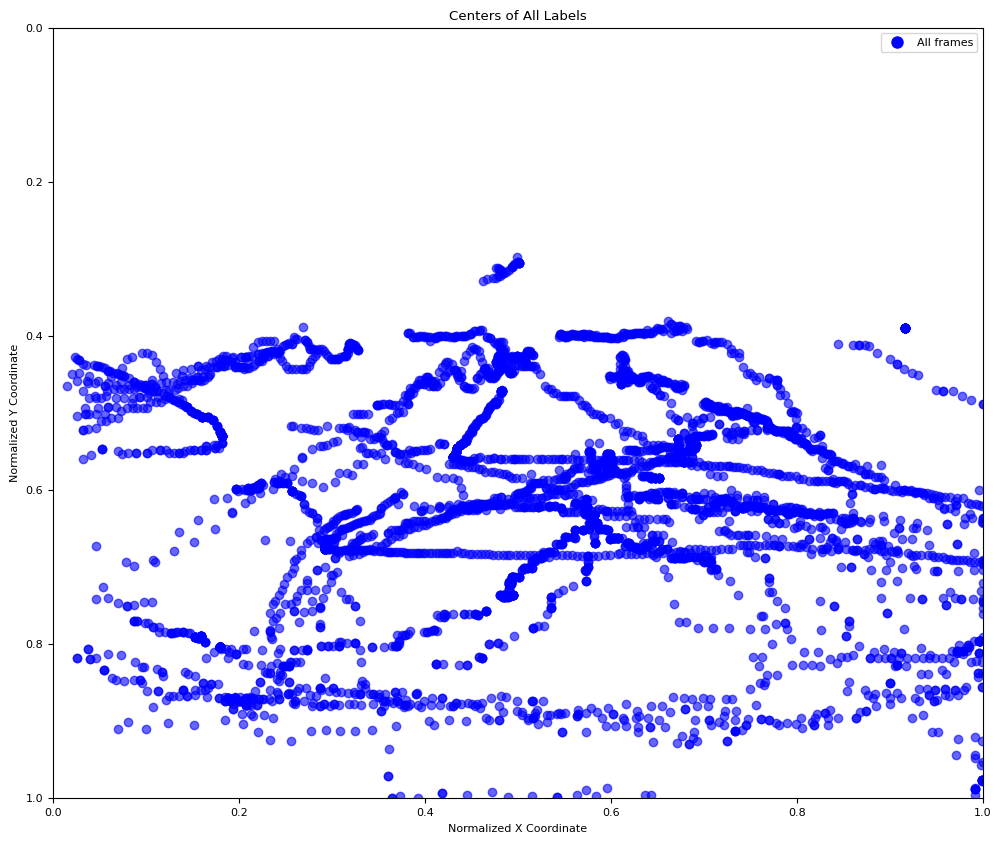

In [239]:
plot_label_centers(all_frames)

As it could be seen, objects are distributed horizontaly (as expected accross the roadway). There are some objects in the edges of camera visibility. Maybe this is because all dash cameras are wide-angled to cover most of the road. This distorts the accuracy of the image to some extent and will cause additional troubles for the detector. Connected points represent the movement of the objects too, because of the nature of the images which are frames extracted from dashcam footages. Looks like we will have problems with **motion blur** too.

### 2.4.2. Bounding box structural analysis

Let's see the bounding boxes structure. **Aspect ratio** - is it a standing/walking person or animal. **Box areas** - most of the boxes are big or small.

Our function accepts two datasets. We refactored it to be able to use it when comparing the ground truth with the predicted in the last part of the research.

Now let's see what is happening here?

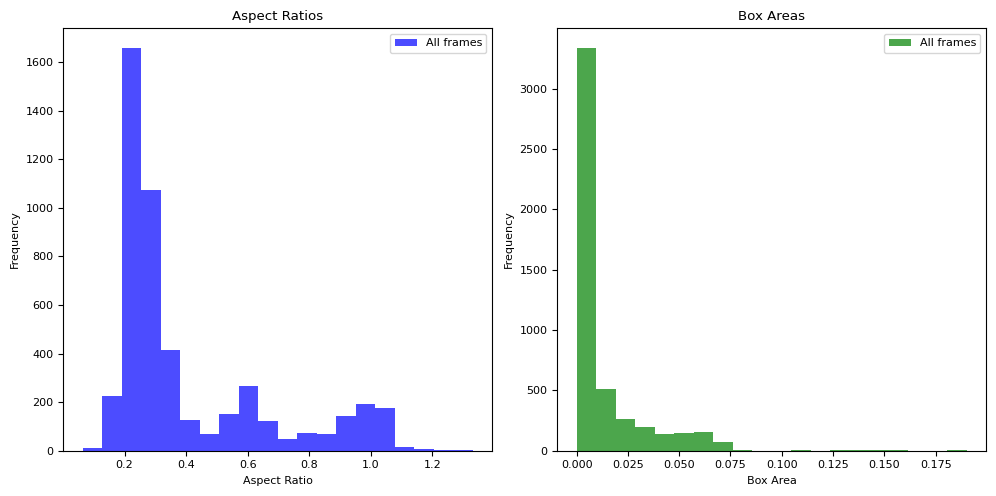

In [240]:
plot_aspect_ratios_and_areas(all_frames, all_frames2=None)

- We can see that most of the boxes are standing up rectangles (hight > width) - may be because most of the annotations are of standing/walking pedestrians (as far as we know cats and dogs don't cross the road upright, at least not yet).
- This can show under representation for some of the classes (most likely small number of annotated pets). We will check that later.
- Analysing the box areas, we can see that most of the bounding boxes are very small, which can create additional difficulties when training the detection model.

### 2.5. The motion blur problem

Extracted frames in the dataset are from dashcam footages. In general this is a video camera mounted usually on the dashboard of a vehicle and used to continuously record activity through the vehicle's windshield. Typically, dashcams are used to gather evidence during traffic accidents. The quality (fps, mpx, etc.) of the footage is not the strongest feature of a dashcam. Inspite the fact that the frames are extracted in 27 fps, it could be expected additional decrease in the quality of the dataset because the dashcam footages are downloaded from Youtube and just only some are aquired from own smartphone camera. It would be a good idea to use footages from high quality 4K camera from better sources than Youtube videos, but that is what we have.

## 3. Preprocessing
The key goal in preprocessing is to ensure the data going into the training process as clean, consistent, and relevant as possible. Proper image preprocessing can significantly improve the performance of object detection models by providing them with high-quality, consistent, and informative input data.

*NB!* Below is the initialization of the project created and trained on Roboflow. The code will download and decompress a huge amount of preprocessed images. The parameter (4) in `version(4)` function points which version of the preprocessed frames will be downloaded. There are 3 versions - v1 , v3 and v4. Every set of frames is organized in directories `train`, `valid` and `test`. The cell does not need to be executed for this notebook to function properly. But if you want to roam amongst  huge amounts (v1 - 5 GB, v3 - 520 MB, v4  - 444 MB) of low quality annotated frames, you can uncomment and execute it on your own risk (kidding).

In [241]:
# rf = Roboflow(api_key="VUZ4GpmqhfyJIQU6enkZ")
# project = rf.workspace("softuni-final-project-dashcam-detector").project("dashcam-detector")
# dataset = project.version(4).download("darknet")
## The dataset will be downloaded and decompressed in the following folder:
# dataset.location

### 3.1. Split the dataset
- Every version contains different number of frames as a result of the augmentation.
- Every version is splitted in different proportions:

|--Version--|--Total frames--|---Training---|---Validating--|---Testing---|
    
    1         30264         92%        4%          4%
    
    3         6883          87%        7%          7%
    
    4         7362          91%        5%          5%

Our images are video frames and are very much identical in-between. We have a lot of work doing the split by maintaining diversibility putting random images in the different sample directories (train/validate/test). Тo make this task easier we used the Roboflow AI Research platform above.

### 3.2. Data augmentation for better model generalisation
Because of the different exposure in different weather conditions and the different parts of the day and night, the different quality of the frames and the distortions from stain and rain drops on the windshield, data augmentation is crucial in image preprocessing especially when considering object detection tasks. 

For better object detection and model generalisation we used different techniques for every model training iteration:

Version 1:

    Auto-Orient: Applied
    Resize: Stretch to 1280x720
    Auto-Adjust Contrast: Using Histogram Equalization
    Tile: 2 rows x 2 columns
    Rotation: Between -15° and +15°
    Grayscale: Apply to 25% of images
    Noise: Up to 5% of pixels 

Version 3:

    Auto-Orient: Applied
    Resize: Stretch to 1280x720
    Auto-Adjust Contrast: Using Histogram Equalization
    Bounding Box: Exposure: Between -25% and +25%

Version 4:

    Auto-Orient: Applied
    Grayscale: Apply to 25% of images
    Brightness: Between -25% and +25%
    Mosaic: Applied 

### 3.3. Pre-training data exploration (if you downloaded the data from Roboflow after all)

If you didn't :
> "These aren't the Droids you're looking for...move along" - Random Stormtrooper, Star Wars Episode IV - New hope

If you did:
> "The force is with you young Skywalker..." - Darth Vader, Star Wars: Episode V - The Empire Strikes

Uncomment and execute the code below to see a collection of 12 preprocessed and augmented frames.

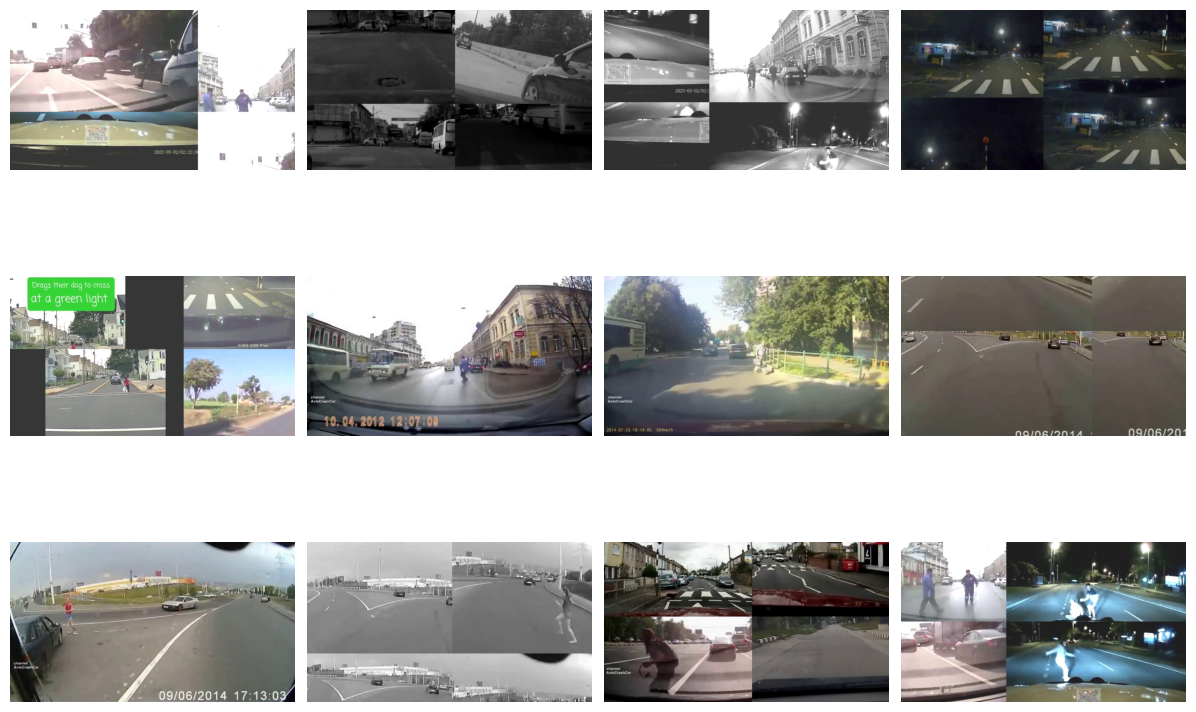

In [242]:
random_grid("Dashcam-Detector-4/train")

We see the result of the applied augmentation techniques. For version 4 they are:

Version 4:

    Auto-Orient: Applied
    Grayscale: Apply to 25% of images
    Brightness: Between -25% and +25%
    Mosaic: Applied

**Balance of class representation**

In part 2.4.2 we assumed a significant imbalance in class representation.

Let's check this. Here is the statistic for the number of annotation by class:

In [243]:
class_balance = all_frames.groupby(by="class").size()

In [244]:
class_balance

class
0    3611
1     419
2     815
dtype: int64

Where: 0 - person, 1 - dog, 2- cat

We see that there is a significant imbalance in the class representation,. This means we have a lot more annotated persons than dogs and cats.

## 4. Training the YOLO v4 Darknet model



The model is being trained using the Roboflow platform. Despite the black box which is this process for us, the platform  provides a flexible enough API to evaluate the model's ability to predict in the next chapter. After all this is a Data Science project.

The type of transfer learning we choose is using the pre-trained YOLO v4 Darknet model trained on COCO (using the weights) and then fine-tune it with own annotated images.

- We replace the last layer(s) to match the number of classes in our custom dataset.
- We then fine-tune and re-train the model on our annotated images using different augmentation techniques. 
- After fine-tuning, the model will be specialized to detect objects from our custom dataset, while leveraging the feature extraction capabilities it learned from the large COCO dataset.

Down below we can find the statistics during the model fitting. These are the curves indicating the change of mAP, box loss, class loss and object loss during the training process. We can iterrate over the different versions by changing the directory `v1` to `v3` or `v4`. We can see some interesting events that happen during the trainig of  **Version 3** - `v3`.

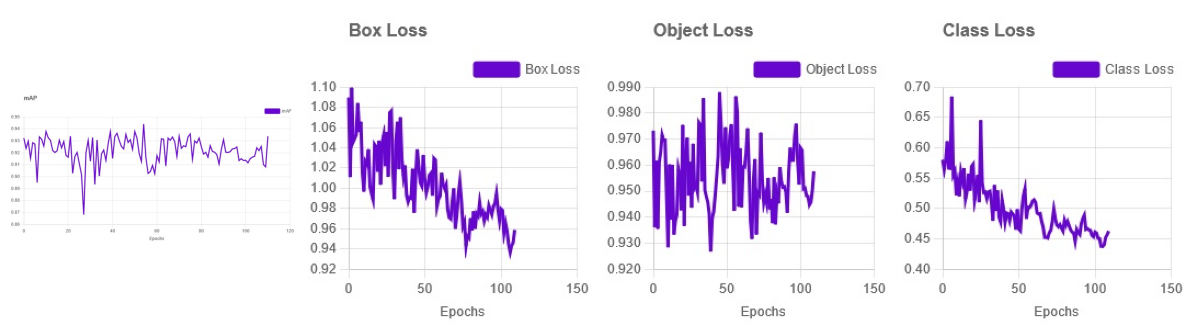

In [245]:
random_grid("data/static/v3")

We won't further analyse the fitting process, because this is not the purpose of this project. 

Let's jump to the next part!

## 5. Evaluating the results

**Intersection over Union (IoU)** is a commonly used metric to evaluate the accuracy of object detection models like YOLO (You Only Look Once). IoU measures the overlap between the ground truth bounding box and the predicted bounding box.

\begin{align}
\text{IoU} = \frac{\text{Area of Overlap}}{\text{Area of Union}}
\end{align}

To compute IoU and evaluate it for our trained YOLO model we have to:

- Get Predicted and Ground Truth Bounding Boxes
  
- Compute IoU for each Predicted Bounding Box as


Find the coordinates of the intersection rectangle:
    
\begin{align*}
x_{\text{min\_intersection}} & = \max(x_{\text{min\_predicted}}, x_{\text{min\_ground\_truth}}) \\
y_{\text{min\_intersection}} & = \max(y_{\text{min\_predicted}}, y_{\text{min\_ground\_truth}}) \\
x_{\text{max\_intersection}} & = \min(x_{\text{max\_predicted}}, x_{\text{max\_ground\_truth}}) \\
y_{\text{max\_intersection}} & = \min(y_{\text{max\_predicted}}, y_{\text{max\_ground\_truth}})
\end{align*}

Compute the area of the intersection rectangle:
\begin{equation*}
\text{Area of Overlap} = (x_{\text{max\_intersection}} - x_{\text{min\_intersection}} + 1) \times (y_{\text{max\_intersection}} - y_{\text{min\_intersection}} + 1)
\end{equation*}

Compute the area of both bounding boxes:
\begin{align*}
\text{Area of Predicted} & = (x_{\text{max\_predicted}} - x_{\text{min\_predicted}} + 1) \times (y_{\text{max\_predicted}} - y_{\text{min\_predicted}} + 1) \\
\text{Area of Ground Truth} & = (x_{\text{max\_ground\_truth}} - x_{\text{min\_ground\_truth}} + 1) \times (y_{\text{max\_ground\_truth}} - y_{\text{min\_ground\_truth}} + 1)
\end{align*}

Compute the area of union:
\begin{align*}
\text{Area of Union} ={\text{Area of Predicted} + \text{Area of Ground Truth} - \text{Area of Overlap}}
\end{align*}
                                          

After reading the data in next cell we will analyse the model performance using:

- Scatter plot of IoU scores аcross the dataset.
- Histogram showing the IoU scores frequency across the dataset
- Confusion matrix

Let's look at the results from our model training iterations. We will read the `csv` source files for the ground truth and predicted samples. Every `csv` file contains information about the annotation file name and the bounding box characteristics- x coordinate, y coordinate, width and height.

### 5.1. Aquisition of ground truth and predicted bounding box samples
First we have to read the `ground_truth_vX.csv` (ground truth) and `predictions_vX.csv` (predicted) csv files for every model training iteration. Files are downloaded with the initial `data.zip` download and should be in the `data` directory

In [246]:
ground_truth_v1 = pd.read_csv("data/ground_truth_v1.csv")
ground_truth_v3 = pd.read_csv("data/ground_truth_v3.csv")
ground_truth_v4 = pd.read_csv("data/ground_truth_v4.csv")
predictions_v1 = pd.read_csv("data/predictions_v1.csv")
predictions_v3 = pd.read_csv("data/predictions_v3.csv")
predictions_v4 = pd.read_csv("data/predictions_v4.csv")

### 5.2. Exploration of the post-training data

Let's look at the ground_truth data and the predicted data. Predicted data is infered with the Roboflow API passing all the ground truth samples to the prediction model.

In [247]:
ground_truth_v1

,filename,class,x,y,width,height
0,1691941173_210523_jpg.rf.11ac928a478ec99d136ef...,0,0.094531,0.777778,0.020313,0.038889
1,1691941178_823352_jpg.rf.7d224dd5085a46a642abf...,0,0.105469,0.775000,0.020313,0.038889
2,1691941186_748531_jpg.rf.e1890e74fb57f70467e59...,0,0.114844,0.777778,0.020313,0.038889
3,1691941206_86039_jpg.rf.6a08b9090a38847c917e6e...,0,0.105469,0.775000,0.020313,0.038889
4,1691941207_678769_jpg.rf.57361c0014595073e76cd...,0,0.144531,0.780556,0.020313,0.033333
...,...,...,...,...,...,...
751,1691943907_802592_jpg.rf.c8021db148f9a1de85dfa...,2,0.616406,0.943056,0.345313,0.113889
752,1691943934_99026_jpg.rf.1238d3f286836b6d00570f...,2,0.078906,0.420833,0.157812,0.691667
753,1691943934_99026_jpg.rf.816325d73aabb54019bfb2...,2,0.913281,0.420833,0.173437,0.691667
754,1691943944_825732_jpg.rf.d4b5e8b0fa563437b2ce4...,2,0.689844,0.408333,0.323437,0.777778


In [248]:
predictions_v1

,image_name,x,y,width,height,confidence,class,image_path,prediction_type
0,1691941173_210523_jpg.rf.11ac928a478ec99d136ef...,119.0,560.0,32.0,20.0,0.721211,cat,data_split_v1/test/1691941173_210523_jpg.rf.11...,ObjectDetectionModel
1,1691941178_823352_jpg.rf.7d224dd5085a46a642abf...,134.5,558.0,31.0,20.0,0.726324,cat,data_split_v1/test/1691941178_823352_jpg.rf.7d...,ObjectDetectionModel
2,1691941186_748531_jpg.rf.e1890e74fb57f70467e59...,146.0,560.0,36.0,22.0,0.769020,cat,data_split_v1/test/1691941186_748531_jpg.rf.e1...,ObjectDetectionModel
3,1691941206_86039_jpg.rf.6a08b9090a38847c917e6e...,133.5,558.0,31.0,20.0,0.712337,cat,data_split_v1/test/1691941206_86039_jpg.rf.6a0...,ObjectDetectionModel
4,1691941207_678769_jpg.rf.57361c0014595073e76cd...,183.5,562.0,33.0,20.0,0.722976,cat,data_split_v1/test/1691941207_678769_jpg.rf.57...,ObjectDetectionModel
...,...,...,...,...,...,...,...,...,...
523,1691943907_802592_jpg.rf.c8021db148f9a1de85dfa...,813.5,677.5,527.0,85.0,0.739291,person,data_split_v1/test/1691943907_802592_jpg.rf.c8...,ObjectDetectionModel
524,1691943934_99026_jpg.rf.1238d3f286836b6d00570f...,128.0,290.5,254.0,495.0,0.573135,person,data_split_v1/test/1691943934_99026_jpg.rf.123...,ObjectDetectionModel
525,1691943934_99026_jpg.rf.816325d73aabb54019bfb2...,1106.0,295.5,346.0,457.0,0.563791,person,data_split_v1/test/1691943934_99026_jpg.rf.816...,ObjectDetectionModel
526,1691943944_825732_jpg.rf.d4b5e8b0fa563437b2ce4...,924.5,262.0,505.0,524.0,0.681424,person,data_split_v1/test/1691943944_825732_jpg.rf.d4...,ObjectDetectionModel


We have a problem here. The ground truth data is normalized but the model returns the real size ot the bounding boxes (x, y, width, height). We need to normalize the prediction bounding boxes using the W = 1280 and H = 720, the size in pixels for every frame.

In [249]:
#Define the width W and height H of the frames
W = 1280
H = 720
#Loop through predictions to normalize the spacial data
predictions = [predictions_v1, predictions_v3, predictions_v4]
for predicted in predictions:
    predicted.x = predicted.x / W
    predicted.y = predicted.y / H
    predicted.width = predicted.width / W
    predicted.height = predicted.height / H

In [250]:
predictions_v1

,image_name,x,y,width,height,confidence,class,image_path,prediction_type
0,1691941173_210523_jpg.rf.11ac928a478ec99d136ef...,0.092969,0.777778,0.025000,0.027778,0.721211,cat,data_split_v1/test/1691941173_210523_jpg.rf.11...,ObjectDetectionModel
1,1691941178_823352_jpg.rf.7d224dd5085a46a642abf...,0.105078,0.775000,0.024219,0.027778,0.726324,cat,data_split_v1/test/1691941178_823352_jpg.rf.7d...,ObjectDetectionModel
2,1691941186_748531_jpg.rf.e1890e74fb57f70467e59...,0.114062,0.777778,0.028125,0.030556,0.769020,cat,data_split_v1/test/1691941186_748531_jpg.rf.e1...,ObjectDetectionModel
3,1691941206_86039_jpg.rf.6a08b9090a38847c917e6e...,0.104297,0.775000,0.024219,0.027778,0.712337,cat,data_split_v1/test/1691941206_86039_jpg.rf.6a0...,ObjectDetectionModel
4,1691941207_678769_jpg.rf.57361c0014595073e76cd...,0.143359,0.780556,0.025781,0.027778,0.722976,cat,data_split_v1/test/1691941207_678769_jpg.rf.57...,ObjectDetectionModel
...,...,...,...,...,...,...,...,...,...
523,1691943907_802592_jpg.rf.c8021db148f9a1de85dfa...,0.635547,0.940972,0.411719,0.118056,0.739291,person,data_split_v1/test/1691943907_802592_jpg.rf.c8...,ObjectDetectionModel
524,1691943934_99026_jpg.rf.1238d3f286836b6d00570f...,0.100000,0.403472,0.198437,0.687500,0.573135,person,data_split_v1/test/1691943934_99026_jpg.rf.123...,ObjectDetectionModel
525,1691943934_99026_jpg.rf.816325d73aabb54019bfb2...,0.864062,0.410417,0.270313,0.634722,0.563791,person,data_split_v1/test/1691943934_99026_jpg.rf.816...,ObjectDetectionModel
526,1691943944_825732_jpg.rf.d4b5e8b0fa563437b2ce4...,0.722266,0.363889,0.394531,0.727778,0.681424,person,data_split_v1/test/1691943944_825732_jpg.rf.d4...,ObjectDetectionModel


Looks good now! 

In the ground truth dataset we have 756 bounding boxes but the model predicted 528. This is around 70%, but doesn't mean much.

Let's explore the confidence of the models predictions:

In [251]:
#Our model versions
versions = ["v1", "v3", "v4"]
#Let's loop through the predictions
for i, version in enumerate(versions):
    mean_confidence = predictions[i]['confidence'].mean()
    print(f'Model {version} - {mean_confidence}')


Model v1 - 0.7429849670240374
Model v3 - 0.7697115992940565
Model v4 - 0.8275877170101136


>"Not great, not terrible" - Anatoly Dyatlov, Chernobyl

We can tell that the Model v4 has best confidence.

However, while confidence metrics provide insights into the model's internal decision-making process, it's essential to also evaluate the model's actual accuracy, precision and IoU. We will do this in `chapter 5.3`. 


Now lets see the spacial distribution of bounding boxes in ground trurth and prediction.

### 5.2.1 Spacial distribution overlap analysis

We use the same function as above but now plotting two distrubution at once. 

But first let's limit the ground truth dataset to the number of predicted using their intersection. 

Input values for `ground_truth` and `prediction`

In [269]:
#Input dataset values
ground_truth = ground_truth_v1
prediction = predictions_v1

#Intersects ground_truth with prediction
def intersect_dataframes(ground_truth, prediction, filename="filename", image_name="image_name"):
    intersection_mask = ground_truth[filename].isin(prediction[image_name])
    intersected_df = ground_truth[intersection_mask]
    return intersected_df

In [270]:
# limit the ground truth dataset to the number of predicted.
intersect_dataframes(ground_truth, prediction)

,filename,class,x,y,width,height
0,1691941173_210523_jpg.rf.11ac928a478ec99d136ef...,0,0.094531,0.777778,0.020313,0.038889
1,1691941178_823352_jpg.rf.7d224dd5085a46a642abf...,0,0.105469,0.775000,0.020313,0.038889
2,1691941186_748531_jpg.rf.e1890e74fb57f70467e59...,0,0.114844,0.777778,0.020313,0.038889
3,1691941206_86039_jpg.rf.6a08b9090a38847c917e6e...,0,0.105469,0.775000,0.020313,0.038889
4,1691941207_678769_jpg.rf.57361c0014595073e76cd...,0,0.144531,0.780556,0.020313,0.033333
...,...,...,...,...,...,...
751,1691943907_802592_jpg.rf.c8021db148f9a1de85dfa...,2,0.616406,0.943056,0.345313,0.113889
752,1691943934_99026_jpg.rf.1238d3f286836b6d00570f...,2,0.078906,0.420833,0.157812,0.691667
753,1691943934_99026_jpg.rf.816325d73aabb54019bfb2...,2,0.913281,0.420833,0.173437,0.691667
754,1691943944_825732_jpg.rf.d4b5e8b0fa563437b2ce4...,2,0.689844,0.408333,0.323437,0.777778


Now lets plot the ground truth and prediction distrubution:

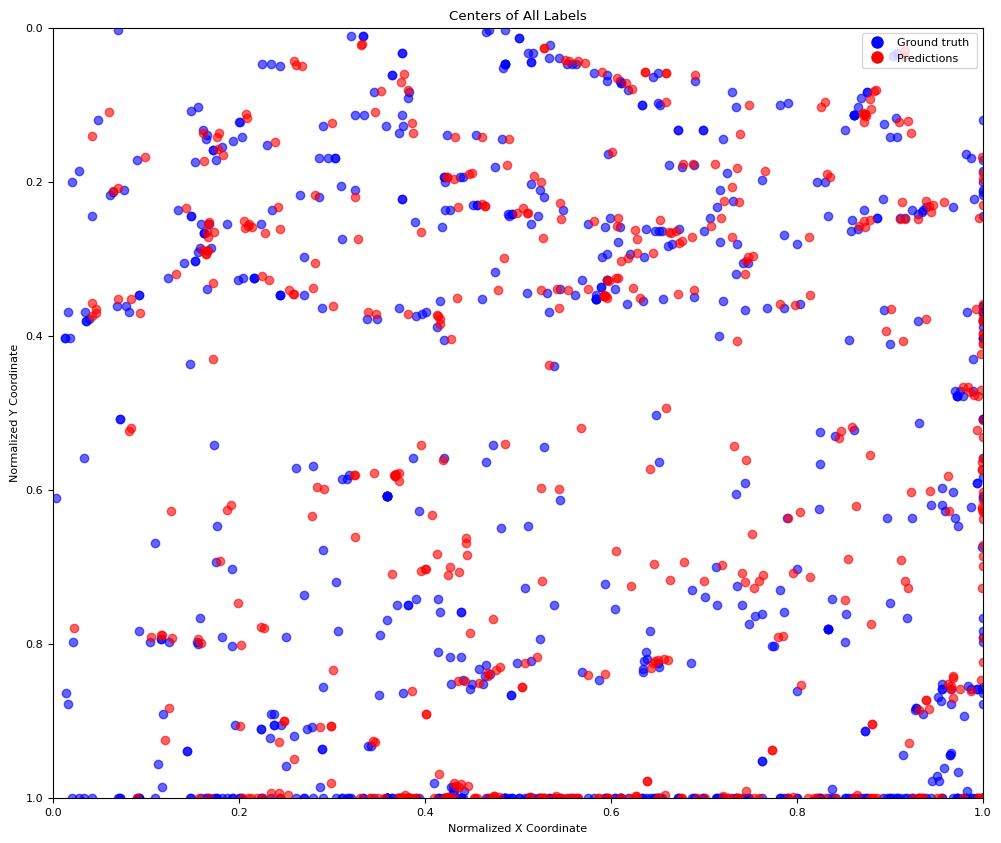

In [254]:
#Plot the centroids
plot_label_centers(ground_truth, prediction, "Ground truth ", "Predictions ")

1. For `ground_truth_v1` and `predictions_v1` we see some clusters with overlap but it is a pretty disperse distribution especially in the middle. We can see  much FP (false positive - false result but reported as correct from the model) It may be result of the biggest training data of around 30 000 images. LEt's check the results of the other model training iterations.
2. For `ground_truth_v3` and `predictions_v3`A lot more clusters with ovelaping centroids. And a lot less dispersion in the middle. We have a cluster with more than dozen ground truth boxes and None predictions on coordinates C(x = 0.65, y = 0.45) We will keep an eye on `predictions_v3` performance.
3. For `ground_truth_v4` and `predictions_v4` gives even better results, we have predictions on the cluster that we mentioned in `predictions_v3`. Looks like the model learns new things.

### 5.2.2. Bounding box structural analysis

Let's compare the bounding boxes structure of ground truth and predicted.

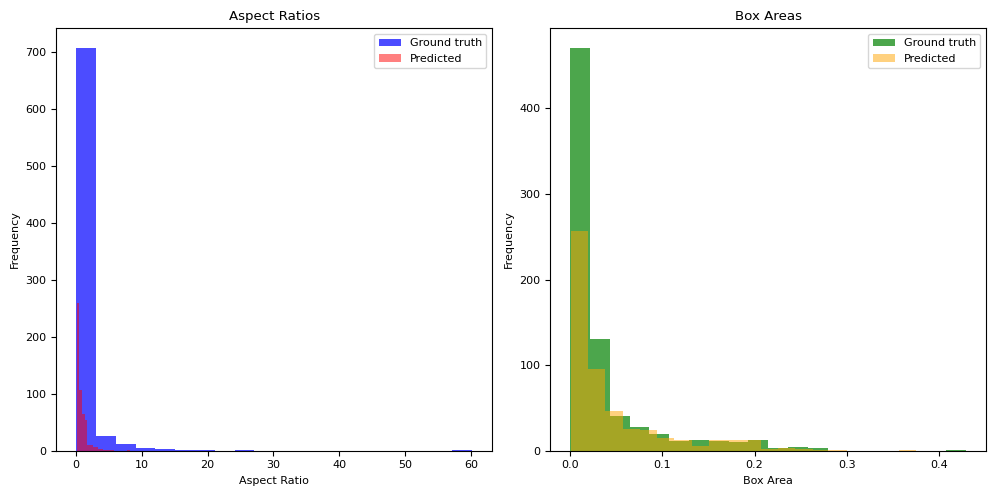

In [255]:
#Put datasets
ground_truth = ground_truth_v1
prediction = predictions_v1

#Plot histogram with aspect ratio and box area of ground truth
plot_aspect_ratios_and_areas(ground_truth, prediction, "Ground truth", "Predicted")

**Version 1** -  The ground truth and predicted follow the same pattern. More standing than laying bounding boxes and most of them have tiny box area.

**Version 3** - A bit different results.We see that the rectangles abit widen. May be the model learned about cats and dogs, or persons on the ground. Box area keeps the pattern from ground truth as general and decreases from 220 to 180 frequency .

**Version 4** - The widening continues, predicted boxes becames wider, but the frequency decreases a bit. Predicted boxes became smaller.

### 5.3. Model performance

**A sneak peak over the calculated with `compute_iou()` function values of Intersection over Unit (IoU).** Input the values of  `ground_truth` and `prediction` versions to see the calculated IoU's. Feel free to explore changing the parameters, below we acn find the aggregated statistics in  a table.

In [256]:
#Enter the dataset you want to explore IoU performance
ground_truth = ground_truth_v1
prediction = predictions_v1

In [257]:
# Initialize an empty list to store IoU values
ious = []
# Iterate over unique filenames in ground_truth_v1
for filename in ground_truth['filename'].unique():

    # Filter rows based on filename and image_name
    ground_truth_subset = ground_truth[ground_truth['filename'] == filename]
    predictions_subset = prediction[prediction['image_name'] == filename]

    # Get the minimum length of the two subsets
    min_length = min(len(ground_truth_subset), len(predictions_subset))

    # Calculate IoU for each corresponding row in the filtered subsets
    for i in range(min_length):
        iou_value = compute_iou(ground_truth_subset.iloc[i], predictions_subset.iloc[i])
        ious.append(iou_value)

# Convert the list of IoU values to a pandas Series
iou_series = pd.Series(ious)
iou_series


0      0.613208
1      0.628019
2      0.603376
3      0.628019
4      0.680628
         ...   
518    0.731455
519    0.595098
520    0.590856
521    0.585172
522    0.699267
Length: 523, dtype: float64

We can see the calculated IoU's for every bounding box. 

Some basic statistics over the IoU distribution.

In [258]:
iou_series.describe()

count    523.000000
mean       0.540859
std        0.328346
min        0.000000
25%        0.187301
50%        0.691207
75%        0.778210
max        0.968948
dtype: float64

Actualy interesting results:

|--Version--|---------Mean--------|---------StDev--------|--Maximum---|
    
    1         0.540859         0.328346        0.968948      
    
    3         0.442568         0.358515        0.955249      
    
    4         0.481983         0.348775        0.957011


`Version 1` has best mean IoU and best maximum IoU and the smallest standart deviation.

### 5.3.1. EDA analysis

Here are the plots that we will analyze. As the name of the function indicates `evaluate_model_performance(ground_truth_dataset, predicted_dataset, threshold)` we can use it to see the overall performance of the model in different metrics. Changing the parameter values will iterate through the different versions of the model training. We can use different IoU thresholds to observe the results.

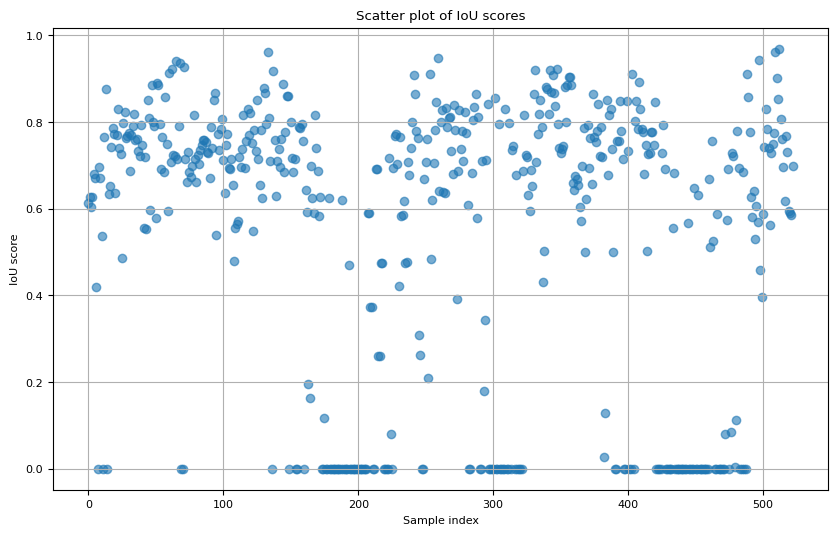

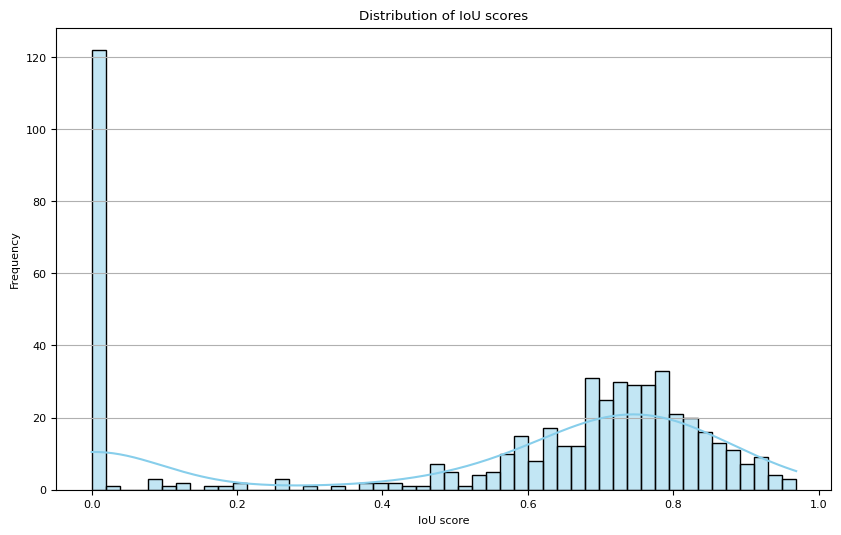

Accuracy (IoU > 0.5): 70.36%
count    523.000000
mean       0.540859
std        0.328346
min        0.000000
25%        0.187301
50%        0.691207
75%        0.778210
max        0.968948
dtype: float64


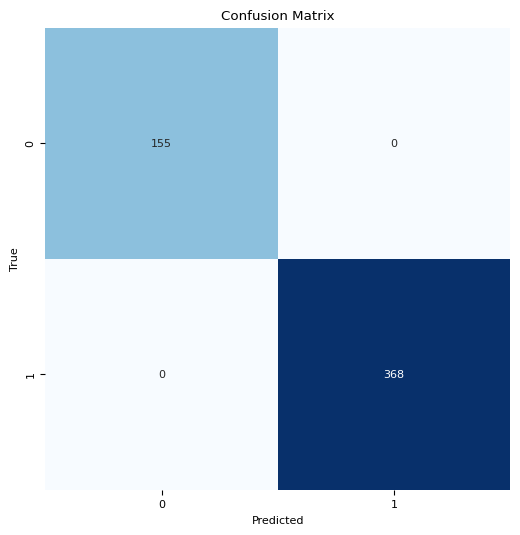

In [259]:
#Enter values to see EDA plots
ground_truth = ground_truth_v1
prediction = predictions_v1
threshold = 0.5

evaluate_model_performance(ground_truth,prediction, threshold)

### 5.3.2. Interpretation of the results

Let's explore the connection between our model training parameters and the results we see above:

**Version 1** `(ground_truth_v1, predictions_v1)`:

Input data:

|--Version--|--Total frames--|---Training---|---Validating--|---Testing---|
   
    1         30264         92%        4%          4%

Preprocessing (over all frames):

- Auto-Orient: Applied
- Resize: Stretch to 1280x720
- Auto-Adjust Contrast: Using Histogram Equalization
- Tile: 2 rows x 2 columns

Augmentations:
 
- Rotation: Between -15° and +15°
- Grayscale: Apply to 25% of images
- Noise: Up to 5% of pixels

Results:
- Accuracy (IoU > 0.5): 70.36% of the predicted bounding boxes were correct when their overlap with the ground truth boxes exceeded 50%
- Accuracy (IoU > 0.6): 63.10% of the predicted bounding boxes were correct when their overlap with the ground truth boxes exceeded 60%
- Accuracy (IoU > 0.7): 47.04% of the predicted bounding boxes were correct when their overlap with the ground truth boxes exceeded 70%
- Accuracy (IoU > 0.8): 17.97%% of the predicted bounding boxes were correct when their overlap with the ground truth boxes exceeded 80%

......................
  

**Version 3** `(ground_truth_v3, predictions_v3)`:


Input data:

|--Version--|--Total frames--|---Training---|---Validating--|---Testing---|
   
    3         6883          87%        7%          7%

Preprocessing:
- Auto-Orient: Applied
- Resize: Stretch to 1280x720
- Auto-Adjust Contrast: Using Histogram Equalization

Augmentations:
- Outputs per training example: 3
- Bounding Box: Exposure: Between -25% and +25%

Results:
- Accuracy (IoU > 0.5): 58.66% of the predicted bounding boxes were correct when their overlap with the ground truth boxes exceeded 50%
- Accuracy (IoU > 0.6): 53.25% of the predicted bounding boxes were correct when their overlap with the ground truth boxes exceeded 60%
- Accuracy (IoU > 0.7): 37.01% of the predicted bounding boxes were correct when their overlap with the ground truth boxes exceeded 70%
- Accuracy (IoU > 0.8): 13.20% of the predicted bounding boxes were correct when their overlap with the ground truth boxes exceeded 80%

.......................

**Version 4** `(train_v4, test_v4)`:


Input data:

|--Version--|--Total frames--|---Training---|---Validating--|---Testing---|
   
    4         7362          91%        5%          5%

Preprocessing:
- Auto-Orient: Applied

Augmentations:
- Grayscale: Apply to 25% of images
- Brightness: Between -25% and +25%
- Mosaic: Applied

Results:
- Accuracy (IoU > 0.5): 66.13% of the predicted bounding boxes were correct when their overlap with the ground truth boxes exceeded 50%
- Accuracy (IoU > 0.6): 60.52% of the predicted bounding boxes were correct when their overlap with the ground truth boxes exceeded 60%
- Accuracy (IoU > 0.7): 37.47% of the predicted bounding boxes were correct when their overlap with the ground truth boxes exceeded 70%
- Accuracy (IoU > 0.8): 13.63%% of the predicted bounding boxes were correct when their overlap with the ground truth boxes exceeded 80%


............................

**Summary**

We have descent results in all model versions for **IoU - 50%**, but **Version 1** performs best. Increasing the number of samples doesn't increase the accuracy much but it helps (Version 1 has 30 000 frames, 5 times more than the other versions). As we can see in the histogram with the distribution of IoU accross all models we have not a small number of  IoU's = 0. This can be False Positive results or True Negative results. But when we look up the confusion matrix we see that those all are True Negative - both the model and the ground truth agree there's no object present. 

Comparing Version 3 and Version 4 which have similar number of training samples , we see that Version 4 performs better. This gives us possible direction for further experiments with some of the preprocessing  and augmentation techniques in **Version 4**:

- Grayscale: Apply to 25% of images
- Brightness: Between -25% and +25%
- Mosaic: Applied




### 5.3.3. Model demonstration

In [261]:
from roboflow import Roboflow
rf = Roboflow(api_key="YOUR-API-TO-ROBOFLOW")
project = rf.workspace().project("dashcam-detector")
model = project.version(3).model

# infer on a local image
print(model.predict("data/images/1691943836_998905.jpg", confidence=40, overlap=30).json())

# visualize your prediction
model.predict("data/images/1691943836_998905.jpg", confidence=40, overlap=30).save("prediction.jpg")

# infer on an image hosted elsewhere
# print(model.predict("URL_OF_YOUR_IMAGE", hosted=True, confidence=40, overlap=30).json())

loading Roboflow workspace...
loading Roboflow project...
{'predictions': [{'x': 575.0, 'y': 363.0, 'width': 166.0, 'height': 174.0, 'confidence': 0.9233824014663696, 'class': 'person', 'image_path': 'data/images/1691943836_998905.jpg', 'prediction_type': 'ObjectDetectionModel'}], 'image': {'width': '1280', 'height': '720'}}


![alternative text](prediction.jpg)

This frame is not a random choice. It is from the ground truth dataset, that's why we have a good match here. If we load a photo that the model does not know we get very fluctuating results. Feel free to experiment with other pictures.

## 6. Conclusions

After all the goal of this project is to validate our initial hypothesis: **Can we use dashcam videos to detect persons, dogs and cats in realtime?** and we want an unambiguous answer. We gathered video frames, we trained a model that detects different obejct (classes). So we validated your question with positive answer - **Yes**. 

- Looking at the frames we found that it is extremely important to have more frames per second when extracting from video files to achive real-time performance.
- Looking at the annotations we found a significant imbalance between the numer of the annotated classes. We need more annotated data for `dogs` and `cats`
- Looking at the model training we found that preproprocessing plays and important part to achive good results.
- The model we use YOLO v4 Darknet is proven state-of-art model for the job we used it, but there are future releases as YOLO v7 which are better as seen below.

So yes, we have the technology, we have the tools, we have the metrics for evaluating the results. I think having the proper training video frames and carefully applying preprocessing will lead to a smooth working Dashcam detector.

This can be a good base to make further research and deploy such a model in a dashcam software. Roboflow gives the option to deploy the trained model on a Raspberry Pi development with camera and validate the model in real-time situations from a moving vehicle.

Maybe we can achive better results using a Single Shot MultiBox Detector model or any other Residual Network (ResNet) model. 

Yes, but this is another story. 

Thank you for your time!

## 7. References

1. Frames extracted from videos from Youtube
2. Frames extracted from own videos shot with Redmi Note 11 pro
3. CSV files with bounding boxes parameters
4. [Object Detection in 4K Dashcam Videos](https://medium.com/@karol_majek/object-detection-in-4k-dashcam-videos-237c30ade356)
5. [OpenCV](https://learnopencv.com/intersection-over-union-iou-in-object-detection-and-segmentation/)
6. [SoftUni Final Project Dashcam detector](https://universe.roboflow.com/softuni-final-project-dashcam-detector/dashcam-detector)
7. [Chat GPT](https://chat.openai.com)